# ***Finite Difference Method For European Option***

Author: Youssef BOUZKRAOUI, Adel ADRAOUI

In [1]:
import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt
import time
import sys
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
r = 0.1
sigma = 0.2
T = 1
K = 100
Smin , Smax = 0 , 200

## 1  The Euler Forward (or Explicit Euler) Scheme
### Preliminaries

In [4]:
# Calculs communs entre les différents méthodes
def simulation(N, I):    
    results = {}  
    
    h = (Smax - Smin) / (I + 1)
    s = Smin + h * np.arange(1, I + 1)
    dt = T / N
    alpha = ((sigma ** 2) / (2 * (h ** 2))) * (s**2)
    beta = (r / (2 * h)) * s

    def u0(s):
        return max(K - s, 0)

    def uleft(t):
        return K * np.exp(-r * t) - Smin

    def uright(t):
        return 0

    A = np.zeros((I, I))
    A[I-1,I-1]= 2 * alpha[I-1] + r
    for i in range(I - 1):
        A[i][i] = 2 * alpha[i] + r
        A[i + 1][i] = -alpha[i + 1] + beta[i + 1]
        A[i][i + 1] = -alpha[i] - beta[i]

    def q(t):
        y = np.zeros((I, 1))
        y[0] = (- alpha[0] + beta[0]) * uleft(t)
        y[I - 1] = (- alpha[I - 1] - beta[I - 1]) * uright(t)
        return y

    phi_s = np.maximum(K - s, 0).reshape(I, 1)

    results['s'] = s
    results['h'] = h
    results['dt'] = dt
    results['A'] = A
    results['q'] = q
    results['phi_s'] = phi_s
    results['alpha'] = alpha
    results['beta'] = beta

    return results

## 2   Programming Explicit Euler (EE)

In [5]:
def EE_simulation(N, I, SCHEME='EE', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I) 
    phi_s = simu["phi_s"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U = phi_s
    for n in range(N):
        t = n * dt
        U = U - dt * (A @ U + q(t))
    return U

In [6]:
def plot_payoff_and_scheme(s, U, K):    
    plt.figure(figsize=(8, 6))
    plt.plot(s, phi_s, label='Payoff du Put')
    plt.plot(s, U.flatten(), label='Schéma de différence finie')
    plt.title('Comparaison Payoff et Schéma de différence finie pour un Put')
    plt.xlabel('Prix de l\'actif sous-jacent')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()

N= 20 I= 20 SCHEME=EE


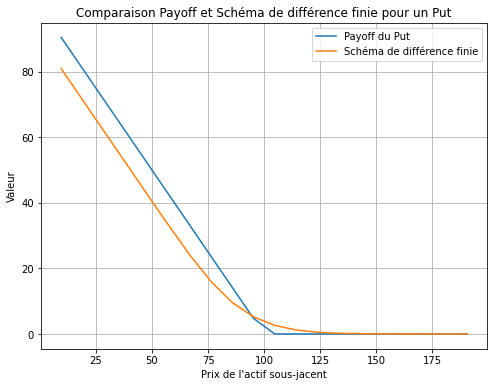

In [7]:
s = simulation(20, 20)['s']
U = EE_simulation(20, 20)
phi_s = simulation(20, 20)['phi_s']
plot_payoff_and_scheme(s, U, K)

## 3    First Numerical Tests

### a/ Test the Euler Forward Scheme EE

In [8]:
def check_stability_and_positivity(U):
    is_stable = np.linalg.norm(U, np.inf) < 1000 #### 1000 valeur prise au hasard
    is_positive = np.all(U >= 0)
    return is_stable, is_positive

For N=10, I=10: Stability - True, Positivity - True
For N=10, I=20: Stability - True, Positivity - True
For N=10, I=50: Stability - False, Positivity - False
For N=10, I=100: Stability - False, Positivity - False


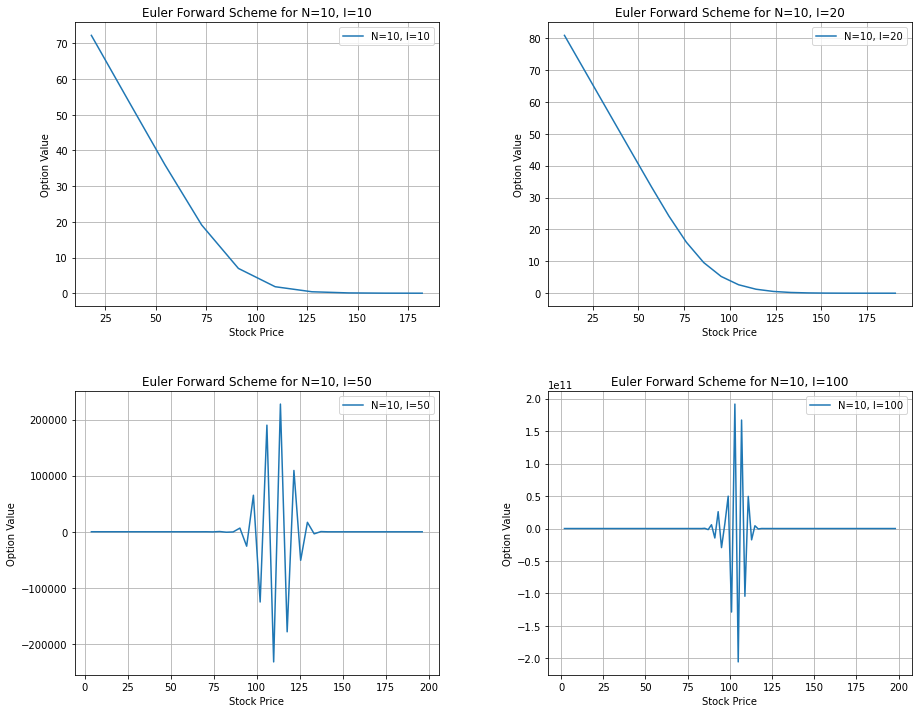

In [9]:
N = 10
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))  # Utiliser une grille 2x2
axes = axes.flatten()  # Aplatir le tableau des axes pour un indexage facile

for idx, I in enumerate([10, 20, 50, 100]):
    U = EE_simulation(N, I, afficher=False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N={N}, I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N, I)['s']
    axes[idx].plot(s, U.flatten(), label=f'N={N}, I={I}')
    axes[idx].set_title(f'Euler Forward Scheme for N={N}, I={I}')
    axes[idx].set_xlabel('Stock Price')
    axes[idx].set_ylabel('Option Value')
    axes[idx].legend()
    axes[idx].grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Ajuster l'espacement entre les graphiques
plt.show()

For N=I=10: Stability - True, Positivity - True
For N=I=20: Stability - True, Positivity - True
For N=I=50: Stability - False, Positivity - False
For N=I=100: Stability - False, Positivity - False


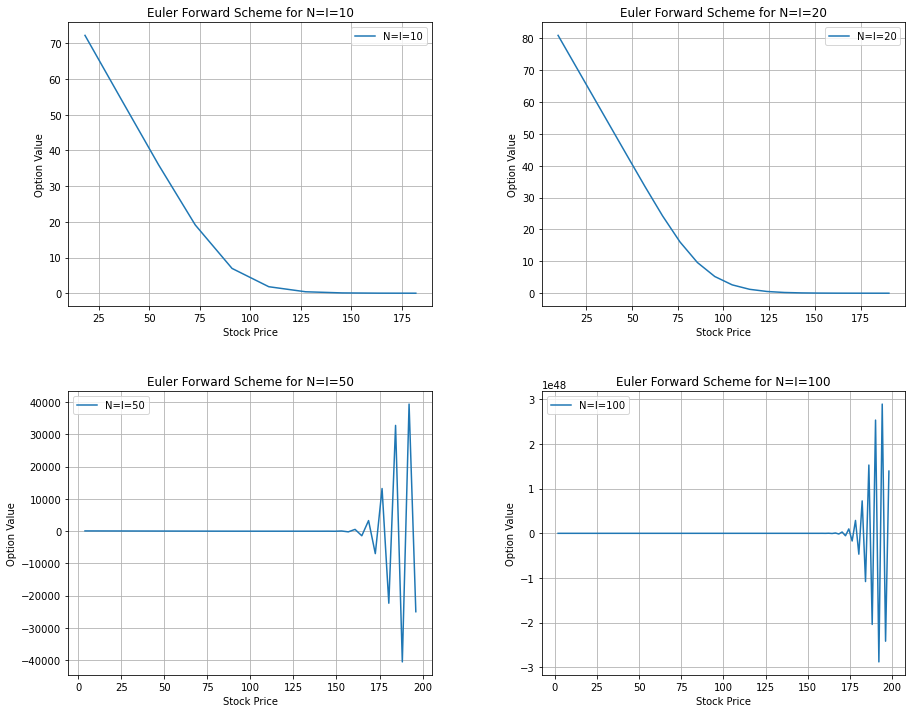

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12)) 
axes = axes.flatten()  

for idx, N_I in enumerate([10, 20, 50, 100]):
    U = EE_simulation(N_I, N_I, afficher=False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N=I={N_I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N_I, N_I)['s']
    axes[idx].plot(s, U.flatten(), label=f'N=I={N_I}')
    axes[idx].set_title(f'Euler Forward Scheme for N=I={N_I}')
    axes[idx].set_xlabel('Stock Price')
    axes[idx].set_ylabel('Option Value')
    axes[idx].legend()
    axes[idx].grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between plots
plt.show()

#### With the help of the `check_stability_and_positivity` function, we can indeed verify that:
#### The Scheme is not always numerically stable (in this example, the norm of U^n explode after I = 50)
#### It doesn't always give a positive solution

### b/ Understanding the origin of the oscillations : 

\begin{align} 
& B := I_d - \Delta t A
\end{align}

In [11]:
def check_positivity_one_norms(U): ######## Positivity, Element greater than 1, Norms inf & 2
    is_positive = np.all(U >= 0)
    is_greater_one = not np.all(np.diag(np.abs(U)) < 1)  # We check if there a modulus  greater than 1 .
    norm_inf , norm_2 = np.linalg.norm(U, np.inf) , np.linalg.norm(U, 2)
    return is_positive, is_greater_one, norm_inf , norm_2

In [12]:
N=10    
I = 50  
EE_simulation(N,I)
sim10_50=simulation(N,I)
dt = sim10_50["dt"]
A = sim10_50["A"]
B = np.ones((I,I)) - dt*A
is_positive, is_greater_one, norm_inf , norm_2 = check_positivity_one_norms(B)
print(f"For B : Positivity - {is_positive}, Greater_One - {is_greater_one}, Norm_inf : {norm_inf}, Norm_2 : {norm_2}")

N= 10 I= 50 SCHEME=EE
For B : Positivity - False, Greater_One - True, Norm_inf : 67.218, Norm_2 : 49.89363480073947


#### The coefficients of B are not all positive  and  they  have a modulus greater than 1 ( in particular at the diagonal elements).
#### Both norms (infinity and 2) are greater than 1.

In [13]:
N=10   
I = 10   
EE_simulation(N,I)
sim10_10=simulation(N,I)
dt = sim10_10["dt"]
A = sim10_10["A"]
B = np.ones((I,I)) - dt*A
is_positive, is_greater_one, norm_inf , norm_2 = check_positivity_one_norms(B)
print(f"For B : Positivity - {is_positive}, Greater_One - {is_greater_one}, Norm_inf : {norm_inf}, Norm_2 : {norm_2}")

N= 10 I= 10 SCHEME=EE
For B : Positivity - True, Greater_One - False, Norm_inf : 9.993, Norm_2 : 9.965724446046933


#### The coefficients of B are all positive, and smaller than 1 (The diagonal elements of B)

### c/ CFL number :
\begin{align} 
& \mu := \frac{\Delta t}{h^2} \sigma^2 S_{max}^2
\end{align}

In [14]:
CFL_10_10 = (sim10_10['dt']/(sim10_10['h']**2)) * (sigma**2) * (Smax**2) # (N,I) = (10,10)
CFL_10_50 = (sim10_50['dt']/(sim10_50['h']**2)) * (sigma**2) * (Smax**2) # (N,I) = (10,50)
print("CFL(10,10) :" +str(CFL_10_10) +"    " +"CFL(10,50) :" +str(CFL_10_50))

CFL(10,10) :0.484    CFL(10,50) :10.404000000000003


#### When \mu is sufficiently small there is no stability problem ((N,I) =(10,10) is stable)

### d/ P1-interpolated value :
\begin{align} 
& U(\hat{s}) \approx \frac{s_{i+1} - \hat{s}}{h} U_i + \frac{\hat{s} - s_i}{h} U_{i+1}.
& if ~~ \hat{s} \in [s_i , s_{i+1}]
\end{align}

In [15]:
def P1_interpolation(N, I, Sval, simulation_function, Method):
    U = simulation_function(N, I,Method, afficher=False)
    sim= simulation(N,I)
    s = sim["s"]
    h = sim["h"]
    for k in range(len(s)-1):
        if Sval >= s[k] and Sval <= s[k+1]:
            return (((s[k+1] - Sval) / h) * U[k] + ((Sval - s[k]) / h) * U[k+1])[0]

In [16]:
## Sval = 90 ; (N,I) = (10,10) ; (N,I) = (10,50)
P1_interpolation(10, 10, 90, EE_simulation,"EE"),P1_interpolation(10, 50, 90, EE_simulation,"EE") 

(7.558797100906322, 6274.262298912861)

### e/ Numerical Order of the Scheme :

##### Black & Scholes Formula for the put option program

In [17]:
# Value given by the exact Black & Scholes Formula (used to compute the exact error errex)
def black_scholes_put(S, K, T, r, sigma):
    # Calcul de d+ et d-
    d_plus = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d_minus = d_plus - sigma * np.sqrt(T)
    # Price
    put_price = K * np.exp(-r * T) * norm.cdf(-d_minus) - S * norm.cdf(-d_plus)
    return put_price

In order to estimate the error, we will  estimate the difference between two successive computations, say $ U^{(k-1)} ~~  and ~~  U^{(k)} $ (obtained with mesh $(I_{k-1}, N_{k-1})~~   and ~~  (I_k, N_k) $, resp.) :
\begin{align}
& e_k := \left| U^{(k-1)}(\hat{s}) - U^{(k)}(\hat{s}) \right| ~~ ~~ (error)
\end{align}

We also compare the value $ U^{(k)} $ with the Value given by the exact Black & Scholes Formula : 
\begin{align}
& e_{ex,k} := \left| U^{(k)}(\hat{s}) - v(t,\hat{s}) \right| ~~ ~~  (errex)
\end{align}

If the error is $ e_k $ for a given parameters $ I = I_k $ and $ N = N_k $, we can estimate the order (at step $ k $) by the formula
\begin{align}
\alpha_k := \frac{\log(e_{k-1}/e_k)}{\log(h_{k-1}/h_k)} \approx \alpha
\end{align}

If $ h_k = h_{k-1}/2 $ as in the questions, then we get $ e_k/e_{k-1} \approx 1/2^\alpha $ and the previous formula gives
\begin{align}
\alpha_k = \frac{\log(e_{k-1}/e_k)}{\log(2)}
\end{align}


In [18]:
def convergence_table(Sval, simulation_function, valeurs_I, valeurs_N, Method):
    data = []
    for I, N in zip(valeurs_I, valeurs_N):
        start_time = time.time()
        U_s = P1_interpolation(N, I, Sval, simulation_function, Method)
        tcpu = time.time() - start_time
        data.append([I, N, U_s, np.nan, np.nan, np.nan, tcpu])  

    df = pd.DataFrame(data, columns=['I', 'N', 'U(s)', 'error', 'alpha', 'errex', 'tcpu'])

    # Calcul de 'error'  'alpha'  et "errex"
    df['error'] = np.abs((df['U(s)'] - df['U(s)'].shift(-1)).shift(1))
    df['error'].iloc[0] = 0  # Fixer la première valeur à 0
    df['alpha'] = np.log(np.abs(df['error'] / df['error'].shift(-1))) / np.log(2)
    df['alpha'].iloc[0] = 0  # Fixer la première valeur à 0
    df['errex'] = np.abs(df['U(s)'] - black_scholes_put(Sval, K, T, r, sigma))   
    df['errex'].iloc[0] = 0 
    df.dropna(subset=['U(s)'],inplace=True)
    return df

In [19]:
Sval = 80
valeurs_I = [10, 20, 40,80,160,320]
valeurs_N =  valeurs_I
convergence_table(Sval,EE_simulation,valeurs_I,valeurs_N,"EE")

,I,N,U(s),error,alpha,errex,tcpu
0,10,10,1.425509e+01,0.000000e+00,0.000000,0.000000e+00,0.001000
1,20,20,1.351532e+01,7.397757e-01,1.923707,2.416537e-01,0.000000
2,40,40,1.332033e+01,1.949874e-01,-15.734138,4.666637e-02,0.001001
3,80,80,-1.061474e+04,1.062806e+04,-218.859178,1.062801e+04,0.001081
4,160,160,-8.121408e+69,8.121408e+69,NaN,8.121408e+69,0.004380


In [20]:
valeurs_N = [int((x**2)/10) for x in valeurs_I]
convergence_table(Sval,EE_simulation,valeurs_I,valeurs_N,"EE")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,10,10,14.255092,0.000000,0.000000,0.000000,0.001002
1,20,40,13.547634,0.707459,1.804525,0.273971,0.000000
2,40,160,13.345106,0.202528,1.929295,0.071443,0.002000
3,80,640,13.291930,0.053175,1.962253,0.018267,0.004001
4,160,2560,13.278284,0.013646,1.980109,0.004621,0.040212


## 4   Implicit Euler Scheme (IE)

The scheme can be written in the vector form as : 
\begin{align} 
& \frac{U^{n+1} - U^n}{\Delta t} + AU^{n+1} + q(t_{n+1}) = 0, & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})
\end{align}

So, after all calculations are done, we obtain: : 
\begin{align} 
& (I_I + \Delta t A)U^{n+1} = U^{n}  - \Delta t . q(t_{n+1}) , & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I}) ~~ ; ~~ q(t_{n+1}) = q(t_{n} + \Delta t)
\end{align}

In [21]:
def IE_simulation(N, I, SCHEME='IE', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    phi_s = simu["phi_s"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U = phi_s
    for n in range(N):
        t = n * dt
        U = lng.solve(np.eye(I) + dt * A , U - dt * q(t + dt)).reshape(-1,1)
    return U

N= 10 I= 50 SCHEME=IE


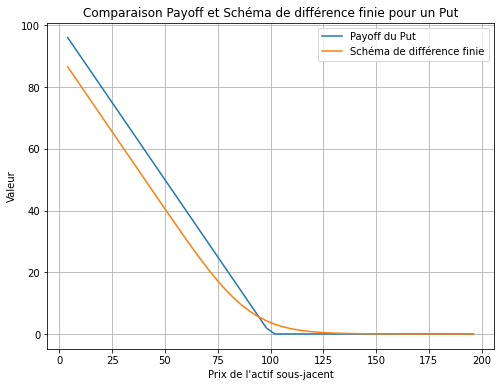

In [22]:
s = simulation(10, 50)['s']
U = IE_simulation(10, 50)
phi_s = simulation(10, 50)['phi_s']
plot_payoff_and_scheme(s, U, K)

For N=10 & I=10: Stability - True, Positivity - True
For N=10 & I=20: Stability - True, Positivity - True
For N=10 & I=50: Stability - True, Positivity - True
For N=10 & I=100: Stability - True, Positivity - True


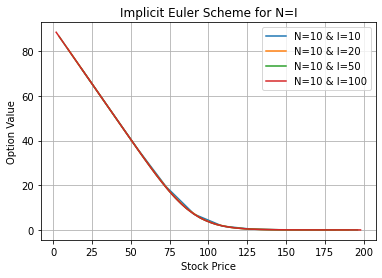

In [23]:
N = 10
for I in [10, 20, 50, 100]:
    U = IE_simulation(N, I,afficher =False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N=10 & I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N, I)['s']
    plt.plot(s, U.flatten(), label=f'N=10 & I={I}')
plt.title('Implicit Euler Scheme for N=I')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()

### a/ There is no more stability problems with the IE Scheme

### b/ The corresponding tables with N = I and with N = I/10

In [24]:
########   N = I
Sval = 80
valeurs_I = [10, 20, 40,80,160,320]
valeurs_N =  valeurs_I
convergence_table(Sval,IE_simulation,valeurs_I,valeurs_N,"IE")

,I,N,U(s),error,alpha,errex,tcpu
0,10,10,14.448406,0.000000,0.000000,0.000000,0.001000
1,20,20,13.642159,0.806247,1.654996,0.368496,0.001000
2,40,40,13.386145,0.256015,1.758961,0.112482,0.001998
3,80,80,13.310502,0.075642,1.690466,0.036839,0.005000
4,160,160,13.287066,0.023436,1.554777,0.013403,0.034299
5,320,320,13.279089,0.007977,NaN,0.005426,0.379805


In [25]:
######  N = I / 10
valeurs_N = [int(x/10) for x in valeurs_I]
convergence_table(Sval,IE_simulation,valeurs_I,valeurs_N,"IE")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,10,1,15.115616,0.000000,0.000000,0.000000,0.000000
1,20,2,14.135687,0.979929,1.066590,0.862024,0.000999
2,40,4,13.667824,0.467863,1.147946,0.394161,0.001360
3,80,8,13.456693,0.211131,1.141429,0.183030,0.001599
4,160,16,13.360985,0.095708,1.095529,0.087322,0.004054


## 5  Crank-Nicolson Scheme (CN)

### a/ The CN scheme in vector form and CN program

The scheme can be written in the vector form as : 
\begin{align} 
& \frac{U^{n+1} - U^n}{\Delta t} + \frac{1}{2}A(U^{n+1}+U^n) + \frac{1}{2}(q(t_{n+1}+q(t_{n})) = 0, & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})
\end{align}

So, after all calculations are done, we obtain: : 
\begin{align} 
& (I_I + \frac{\Delta t}{2} A)U^{n+1} = U^{n}  - \frac{\Delta t}{2} . (AU^{n}+q(t_{n})+q(t_{n+1})) , & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})  ~~ ; ~~ q(t_{n+1}) = q(t_{n} + \Delta t)
\end{align}

In [26]:
def CN_simulation(N, I, SCHEME='CN', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)
    simu = simulation(N, I)
    phi_s = simu["phi_s"]
    dt = simu["dt"]
    A = simu["A"]
    q = simu["q"]
    U = phi_s
    for n in range(N):
        t = n * dt
        U = lng.solve(np.eye(I) + (dt/2) * A , U - (dt/2) * ( A@U + q(t) + q(t+dt))).reshape(-1,1)
    return U

N= 10 I= 50 SCHEME=CN


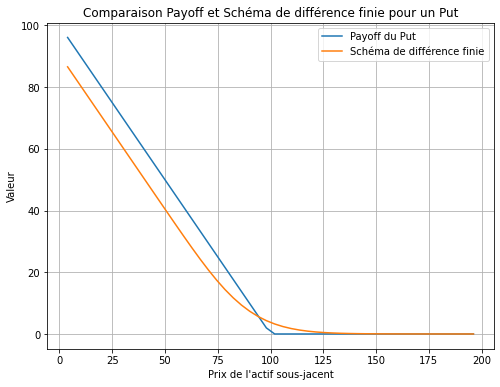

In [27]:
s = simulation(10, 50)['s']
U = CN_simulation(10, 50)
phi_s = simulation(10, 50)['phi_s']
plot_payoff_and_scheme(s, U, K)

For N=10 & I=10: Stability - True, Positivity - True
For N=10 & I=20: Stability - True, Positivity - True
For N=10 & I=50: Stability - True, Positivity - True
For N=10 & I=100: Stability - True, Positivity - True


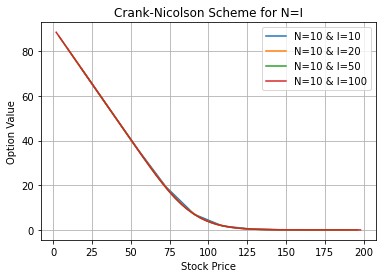

In [28]:
N = 10
for I in [10, 20, 50, 100]:
    U = CN_simulation(N, I,afficher =False)
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N=10 & I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    s = simulation(N, I)['s']
    plt.plot(s, U.flatten(), label=f'N=10 & I={I}')
plt.title('Crank-Nicolson Scheme for N=I')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()

### b/ The corresponding tables with N = I and with N = I/10

In [29]:
########   N = I
Sval = 80
valeurs_I = [10, 20, 40,80,160,320]
valeurs_N =  valeurs_I
convergence_table(Sval,CN_simulation,valeurs_I,valeurs_N,"CN")

,I,N,U(s),error,alpha,errex,tcpu
0,10,10,14.353451,0.000000,0.000000,0.000000,0.000999
1,20,20,13.578892,0.774559,1.778634,0.305229,0.001005
2,40,40,13.353140,0.225752,1.931188,0.079477,0.001996
3,80,80,13.293944,0.059195,1.965551,0.020281,0.004521
4,160,160,13.278788,0.015156,1.981984,0.005125,0.036660
5,320,320,13.274951,0.003837,NaN,0.001288,0.463060


In [30]:
######  N = I / 10
valeurs_N = [int(x/10) for x in valeurs_I]
convergence_table(Sval,CN_simulation,valeurs_I,valeurs_N,"CN")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,10,1,14.230461,0.000000,0.000000,0.000000,0.000000
1,20,2,13.506181,0.724281,2.079206,0.232518,0.001183
2,40,4,13.334783,0.171397,1.898109,0.061120,0.000522
3,80,8,13.288798,0.045985,2.024001,0.015135,0.001508
4,160,16,13.277492,0.011307,1.980378,0.003829,0.003994


## Complement . 1 "Black & Scholes Formula"

##### Section already covered in previous parts, especially in the calculation of the exact error 'errex' for different methods and the creation of various tables. The program for the Black & Scholes formula for the put option is available  is available at the beginning of section "e/ Numerical Order of the Scheme", and the tables requested for EI and CN have already been completed in previous questions

## Complement . 2 "Improved efficiency using sparse matrices"

In [31]:
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags

def create_sparse_matrix(I, alpha, beta, r):
    # Diagonale principale
    diagonal = 2 * alpha + r
    diagonal[-1] += r  # Ajustement pour le dernier élément de la diagonale principale

    # Sous-diagonale (éléments sous la diagonale principale)
    sub_diagonal = -alpha[1:] + beta[1:]

    # Sur-diagonale (éléments au-dessus de la diagonale principale)
    sup_diagonal = -alpha[:-1] - beta[:-1]

    # Création de la matrice creuse
    diagonals = [sub_diagonal, diagonal, sup_diagonal]
    A_sparse = diags(diagonals, offsets=[-1, 0, 1], shape=(I, I), format='csr')
    return A_sparse

In [32]:
def scheme_simulation_sparse(N, I, Method , afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % Method)
    phi_s = simulation(N, I)["phi_s"]
    dt = simulation(N, I)["dt"]
    alpha = simulation(N, I)["alpha"]
    beta = simulation(N, I)["beta"]
    A = create_sparse_matrix(I, alpha, beta, r)
    q = simulation(N, I)["q"]
    U = phi_s
    if Method == "EE":
        for n in range(N):
            t = n * dt
            U = U - dt * (A @ U + q(t))  
    elif Method == "IE":
        for n in range(N):
            t = n * dt
            U = lng.solve(np.eye(I) + (dt/2) * A , U - (dt/2) * ( A@U + q(t) + q(t+dt))).reshape(-1,1)
    elif Method == "CN":
        for n in range(N):
            t = n * dt
            U = lng.solve(np.eye(I) + (dt/2) * A , U - (dt/2) * ( A@U + q(t) + q(t+dt))).reshape(-1,1)
    return U

### Comparison of the execution speed between the two methods of constructing matrix A

##### EE

In [33]:
valeurs_I=[400,800]
valeurs_N = [int((x**2) / 10) for x in valeurs_I]  
df_convergence = convergence_table(Sval, scheme_simulation_sparse, valeurs_I, valeurs_N, "EE")
df_convergence[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,16000,13.274408,0.000000,0.0,0.000000,0.185751
1,800,64000,13.273850,0.000558,NaN,0.000187,0.784576


In [34]:
######  N = I / 10
valeurs_N = [int((x**2)/10) for x in valeurs_I]
convergence_table(Sval,EE_simulation,valeurs_I,valeurs_N,"EE")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,16000,13.274408,0.000000,0.0,0.000000,0.247588
1,800,64000,13.273850,0.000558,NaN,0.000187,3.321528


##### IE

In [35]:
valeurs_I=[400,800,1600]
valeurs_N = [int(x / 10) for x in valeurs_I]  
df_convergence = convergence_table(Sval, scheme_simulation_sparse, valeurs_I, valeurs_N, "IE")
df_convergence[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,40,13.274281,0.000000,0.000000,0.000000,0.097134
1,800,80,13.273818,0.000463,1.995187,0.000155,0.705105
2,1600,160,13.273702,0.000116,NaN,0.000039,6.724411


In [36]:
######  N = I / 10
valeurs_N = [int(x/10) for x in valeurs_I]
convergence_table(Sval,IE_simulation,valeurs_I,valeurs_N,"IE")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,40,13.307505,0.000000,0.00000,0.000000,0.100353
1,800,80,13.290397,0.017108,1.02379,0.016734,0.821222
2,1600,160,13.281982,0.008414,NaN,0.008319,7.790888


##### CN

In [37]:
valeurs_N = [int(x / 10) for x in valeurs_I]  
df_convergence = convergence_table(Sval, scheme_simulation_sparse, valeurs_I, valeurs_N, "CN")
df_convergence[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,40,13.274281,0.000000,0.000000,0.000000,0.086414
1,800,80,13.273818,0.000463,1.995187,0.000155,0.706000
2,1600,160,13.273702,0.000116,NaN,0.000039,6.886954


In [38]:
######  N = I / 10
valeurs_N = [int(x/10) for x in valeurs_I]
convergence_table(Sval,CN_simulation,valeurs_I,valeurs_N,"CN")[:5]

,I,N,U(s),error,alpha,errex,tcpu
0,400,40,13.274281,0.000000,0.000000,0.000000,0.097308
1,800,80,13.273818,0.000463,1.995187,0.000155,0.826718
2,1600,160,13.273702,0.000116,NaN,0.000039,8.010857


#### The sparse matrix approach leads to faster execution times for large N and I, as sparse matrices are more efficient both in terms of memory usage and computation time for matrices with a lot of zero elements.

## Complement. 3 "Call Option"

### a/b/  PDE for the call option, using the boundary conditions

A PDE for the Call Option, using these boundary condition:

\begin{equation} 
\begin{cases} 
& \frac{\partial V}{\partial t} - rS \frac{\partial V}{\partial S} - \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rV = 0, \quad \text{for } s \in (S_{\text{min}}, S_{\text{max}}), \ t \in (0, T) \\
& V(t, S_{\text{min}}) = V_l(t) = 0, \quad \text{for } t \in (0, T) \\
& V(t, S_{\text{max}}) = V_r(t) = S_{\text{max}} - K e^{-rt}, \quad \text{for } t \in (0, T) \\
& V(0, s) = \phi(s) := \max(s - K, 0), \quad \text{for } s \in (S_{\text{min}}, S_{\text{max}})
\end{cases}
\end{equation}

The Implicit Euler Scheme ("IE" SCHEME), with centered difference approximation for the first spacial derivative, is :

\begin{equation} 
\begin{cases} 
& \frac{U_j^{n+1} - U_j^n}{\Delta t} + \frac{\sigma^2}{2} s_j^2 \frac{-U_{j-1}^{n+1} + 2U_j^{n+1} - U_{j+1}^{n+1}}{h^2} - r s_j \frac{U_{j+1}^{n+1} - U_{j-1}^{n+1}}{2h} + r U_j^{n+1} = 0, & n = 0  , \ldots, N-1, \ j = 1, \ldots, I \\
& U_0^{n+1} = V_l(t_{n+1}) = 0, & n = 0  , \ldots, N-1 \\
& U_{I+1}^{n+1} = V_r(t_{n+1}) = S_{\text{max}} - K e^{-r t_{n+1}}  , & n = 0  , \ldots, N-1 \\
& U_j^0 = (s_j - K)^+, & j = 1, \ldots, I
\end{cases}
\end{equation}

The scheme, in vector form, can be written (as in the previous sections) : 

\begin{align} 
& \frac{U^{n+1} - U^n}{\Delta t} + AU^{n+1} + q(t_{n+1}) = 0, & n = 0  , \ldots, N-1 \\
&  with : U^0 = (\phi(s_i))_{1 \leq i \leq I})
\end{align}

### b/ Program and test the IE scheme for the call option

In [39]:
def simulation_Call_IE(N, I, SCHEME='IE', afficher=True):
    if afficher:
        print('N=%3i' % N, 'I=%3i' % I, 'SCHEME=%s' % SCHEME)   
    results = {}  
    
    h = (Smax - Smin) / (I + 1)
    s = Smin + h * np.arange(1, I + 1)
    dt = T / N
    alpha = ((sigma ** 2) / (2 * (h ** 2))) * (s**2)
    beta = (r / (2 * h)) * s

    def u0(s):
        return max(s - K, 0)

    def uleft(t):
        return  0

    def uright(t):
        return Smax - K * np.exp(-r * t)

    A = np.zeros((I, I))
    A[I-1,I-1]= 2 * alpha[I-1] + r
    for i in range(I - 1):
        A[i][i] = 2 * alpha[i] + r
        A[i + 1][i] = -alpha[i + 1] + beta[i + 1]
        A[i][i + 1] = -alpha[i] - beta[i]

    def q(t):
        y = np.zeros((I, 1))
        y[0] = (- alpha[0] + beta[0]) * uleft(t)
        y[I - 1] = (- alpha[I - 1] - beta[I - 1]) * uright(t)
        return y

    phi_s = np.maximum(s - K, 0).reshape(I, 1)
    U = phi_s
    for n in range(N):
        t = n * dt
        U = lng.solve(np.eye(I) + dt * A , U - dt * q(t + dt)).reshape(-1,1)

    results['s'] = s
    results['h'] = h
    results['dt'] = dt
    results['A'] = A
    results['U'] = U
    results['q'] = q
    results['phi_s'] = phi_s
    results['alpha'] = alpha
    results['beta'] = beta

    return results

N= 20 I= 20 SCHEME=IE


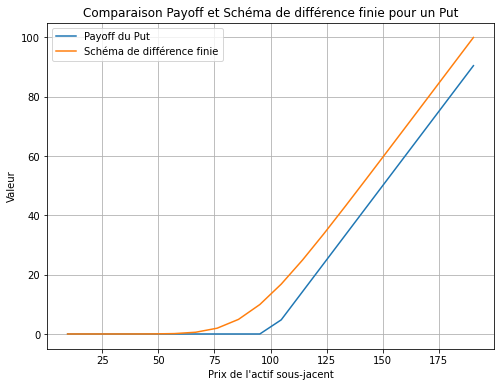

In [40]:
simulation = simulation_Call_IE(20,20)
s = simulation['s']
U = simulation["U"]
phi_s = simulation['phi_s']
plot_payoff_and_scheme(s, U, K)

For N=10 & I=10: Stability - True, Positivity - True
For N=10 & I=20: Stability - True, Positivity - True
For N=10 & I=50: Stability - True, Positivity - True
For N=10 & I=100: Stability - True, Positivity - True


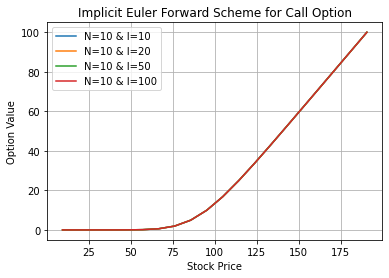

In [41]:
N = 10
for I in [10, 20, 50, 100]:
    is_stable, is_positive = check_stability_and_positivity(U)
    print(f"For N=10 & I={I}: Stability - {is_stable}, Positivity - {is_positive}")
    plt.plot(s, U.flatten(), label=f'N=10 & I={I}')
plt.title('Implicit Euler Forward Scheme for Call Option')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()